In [4]:
STUDY_NAME = 'Subsea_Study[7]'

## Prepare generated cases

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pyfas as fa
import os
import sys
import json
import re
import importlib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

from utils import *
import config

In [6]:
ROOT = config.ROOT
ROOT_SLASH = config.ROOT_SLASH
DATA_PATH = config.DATA_PATH

STUDY_PATH = f'{DATA_PATH}/{STUDY_NAME}'
GEN_DFS_PATH = f'{STUDY_PATH}/gens'
TPL_PATH = f'{ROOT_SLASH}\\olga_proj\\{STUDY_NAME}'

In [9]:
with open('columns.json') as infile:
    cols = json.load(infile)

In [10]:
def rm_unuseful_files(TPL_PATH):
    for fname in os.listdir(TPL_PATH):
        if fname.endswith(".out") or fname.endswith(".ppl") or fname.endswith(".rsw"):
            os.remove(os.path.join(TPL_PATH, fname))

In [11]:
def rm_zero_files(TPL_PATH):
    for fname in os.listdir(TPL_PATH):
        file = os.path.join(TPL_PATH, fname)
        if os.stat(file).st_size == 0:
            os.remove(file)

In [12]:
def tpl_to_csv(f, TPL_PATH, fname):
    try:
        tpl = fa.Tpl(f'{TPL_PATH}\\{fname}.tpl')
        tpl.to_csv()
        flag, stream = True, 'stdout'
    except Exception as e:
        exception = e
        flag, stream = False, 'stderr'
        
    stream = getattr(sys, stream)
    out = f'''[{f:.0f}%] {fname} {'done' if flag else repr(exception)}'''
    print (out)
    stream.flush()

In [13]:
rm_unuseful_files(TPL_PATH)
rm_zero_files(TPL_PATH)

In [14]:
tpl_files = list_ext(TPL_PATH, 'tpl')
csv_files = list_ext(TPL_PATH, 'csv')

In [15]:
csv_set = set([csv_file[:-4] for csv_file in csv_files])
tpl_set = set(tpl_files)
process_files = tpl_set - csv_set

total_lenth = len(process_files)
print(f'Files to be processed {total_lenth}')

parsed = Parallel(n_jobs=4, backend='threading')(delayed(tpl_to_csv)(f / total_lenth * 100, TPL_PATH, fname) for f, fname in enumerate(process_files, start=1))

Files to be processed 73
[4%] 506_GOR-170, 172_WC-40, 46 KeyError('CATALOG')[3%] 534_GOR-170, 172_WC-75, 79 KeyError('CATALOG')[5%] 493_GOR-165, 170_WC-70, 73 KeyError('CATALOG')[1%] 540_GOR-170, 172_WC-75, 79 KeyError('CATALOG')



[7%] 515_GOR-170, 172_WC-40, 46 KeyError('CATALOG')[8%] 486_GOR-165, 170_WC-90, 95 KeyError('CATALOG')
[10%] 546_GOR-170, 172_WC-80, 84 KeyError('CATALOG')

[11%] 533_GOR-170, 172_WC-75, 79 KeyError('CATALOG')
[12%] 504_GOR-165, 170_WC-70, 73 KeyError('CATALOG')[14%] 532_GOR-170, 172_WC-75, 79 KeyError('CATALOG')
[15%] 508_GOR-170, 172_WC-40, 46 KeyError('CATALOG')

[16%] 541_GOR-170, 172_WC-80, 84 KeyError('CATALOG')
[18%] 503_GOR-165, 170_WC-70, 73 KeyError('CATALOG')
[19%] 538_GOR-170, 172_WC-75, 79 KeyError('CATALOG')[21%] 516_GOR-170, 172_WC-40, 46 KeyError('CATALOG')
[22%] 535_GOR-170, 172_WC-75, 79 KeyError('CATALOG')

[23%] 517_GOR-170, 172_WC-50, 56 KeyError('CATALOG')[25%] 483_GOR-165, 170_WC-90, 95 KeyError('CATALOG')

[27%] 500_GOR-165, 170_WC-7

In [16]:
tpl_files = list_ext(TPL_PATH, 'tpl')
csv_files = list_ext(TPL_PATH, 'csv')
f'{len(csv_files)} out of {len(tpl_files)} ({np.round(len(csv_files)/len(tpl_files)*100, 1)}%) without errors'

'478 out of 551 (86.8%) without errors'

### Plot 10 random files

In [17]:
gens = []
lsts = []
path_norm = re.sub(r'\\', '/', TPL_PATH)
pressures = ['AVG_WHP_P', 'AVG_DOWNHOLE_PRESSURE', 'DP_CHOKE_SIZE']
rates = ['BORE_GAS_VOL', 'BORE_WAT_VOL', 'BORE_OIL_VOL']
to_drop = ['Unnamed: 0', 'VOLGBL GLOBAL (-) Global max volume error since last write', 'HT GLOBAL (S) Time step']
csv_files_ordered = csv_files
np.random.shuffle(csv_files)

for fname in tqdm(csv_files[0:20]):
    gen = pd.read_csv(f"{path_norm}/{fname}.csv", sep=',')
        
    gen = gen.drop(columns=to_drop)
    gen = gen.rename(columns=cols)

    gen.DATEPRD /= 86400         # sec do day
    gen.AVG_CHOKE_SIZE_P *= 1e2  # shares to %
    gen[pressures] /= 1e5        # Pa to bar
    gen[rates] *= 86400          # Sm3/S to Sm3/d
    
    gen['Day'] = np.trunc(gen.DATEPRD).astype(int)
    lst = gen.groupby('Day').tail(1).reset_index(drop=True).set_index('Day')
    lst = lst.drop(columns='DATEPRD')
    gen = gen.set_index("DATEPRD")
    gens.append(gen)
    lsts.append(lst)

C:\Users\Asus\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


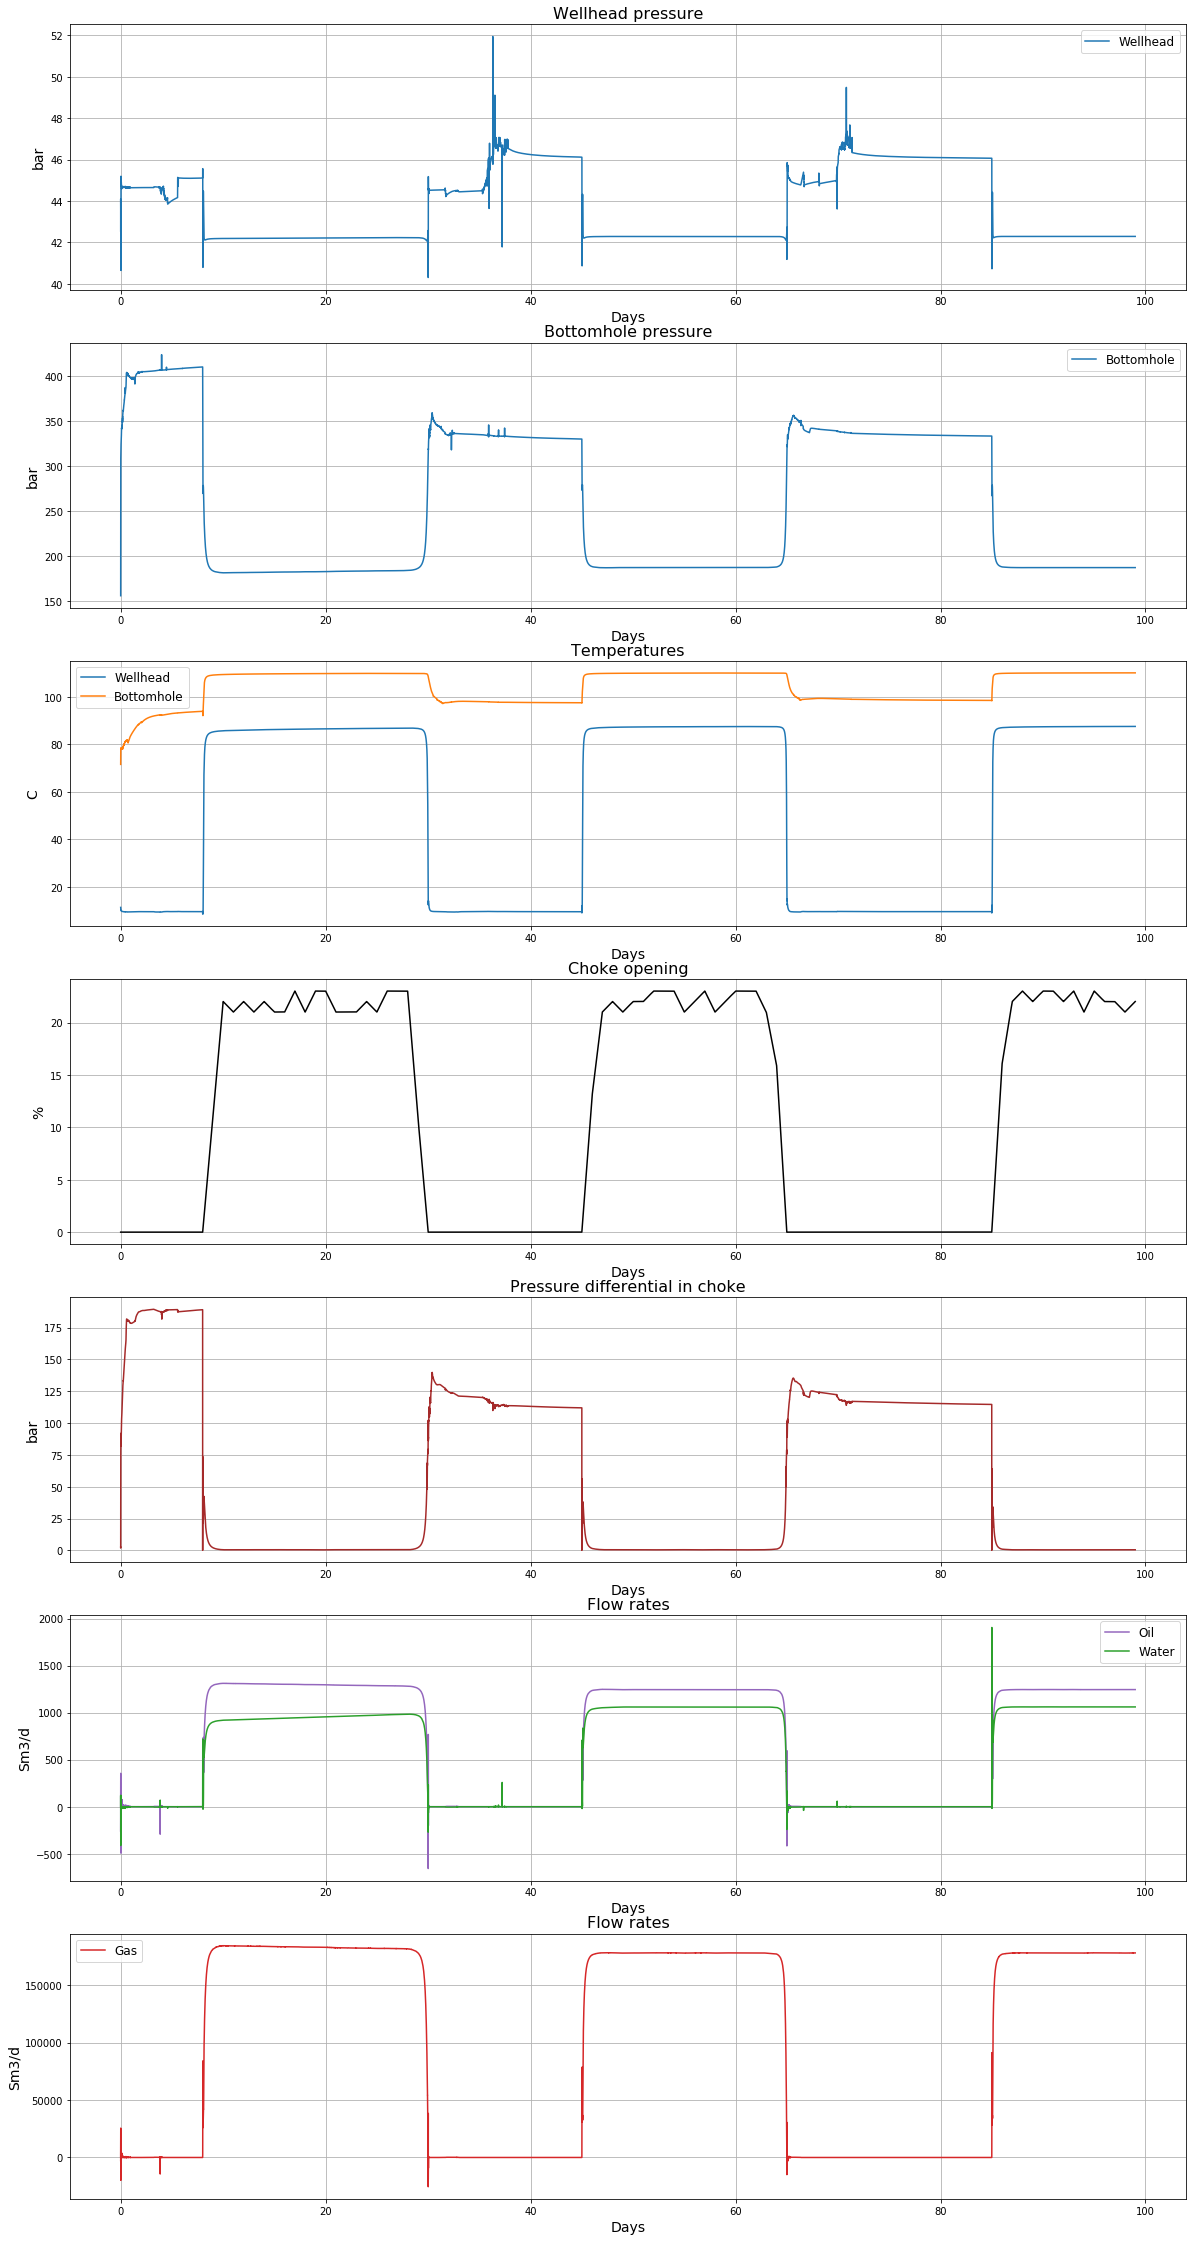

In [19]:
plot_color(gens[1])

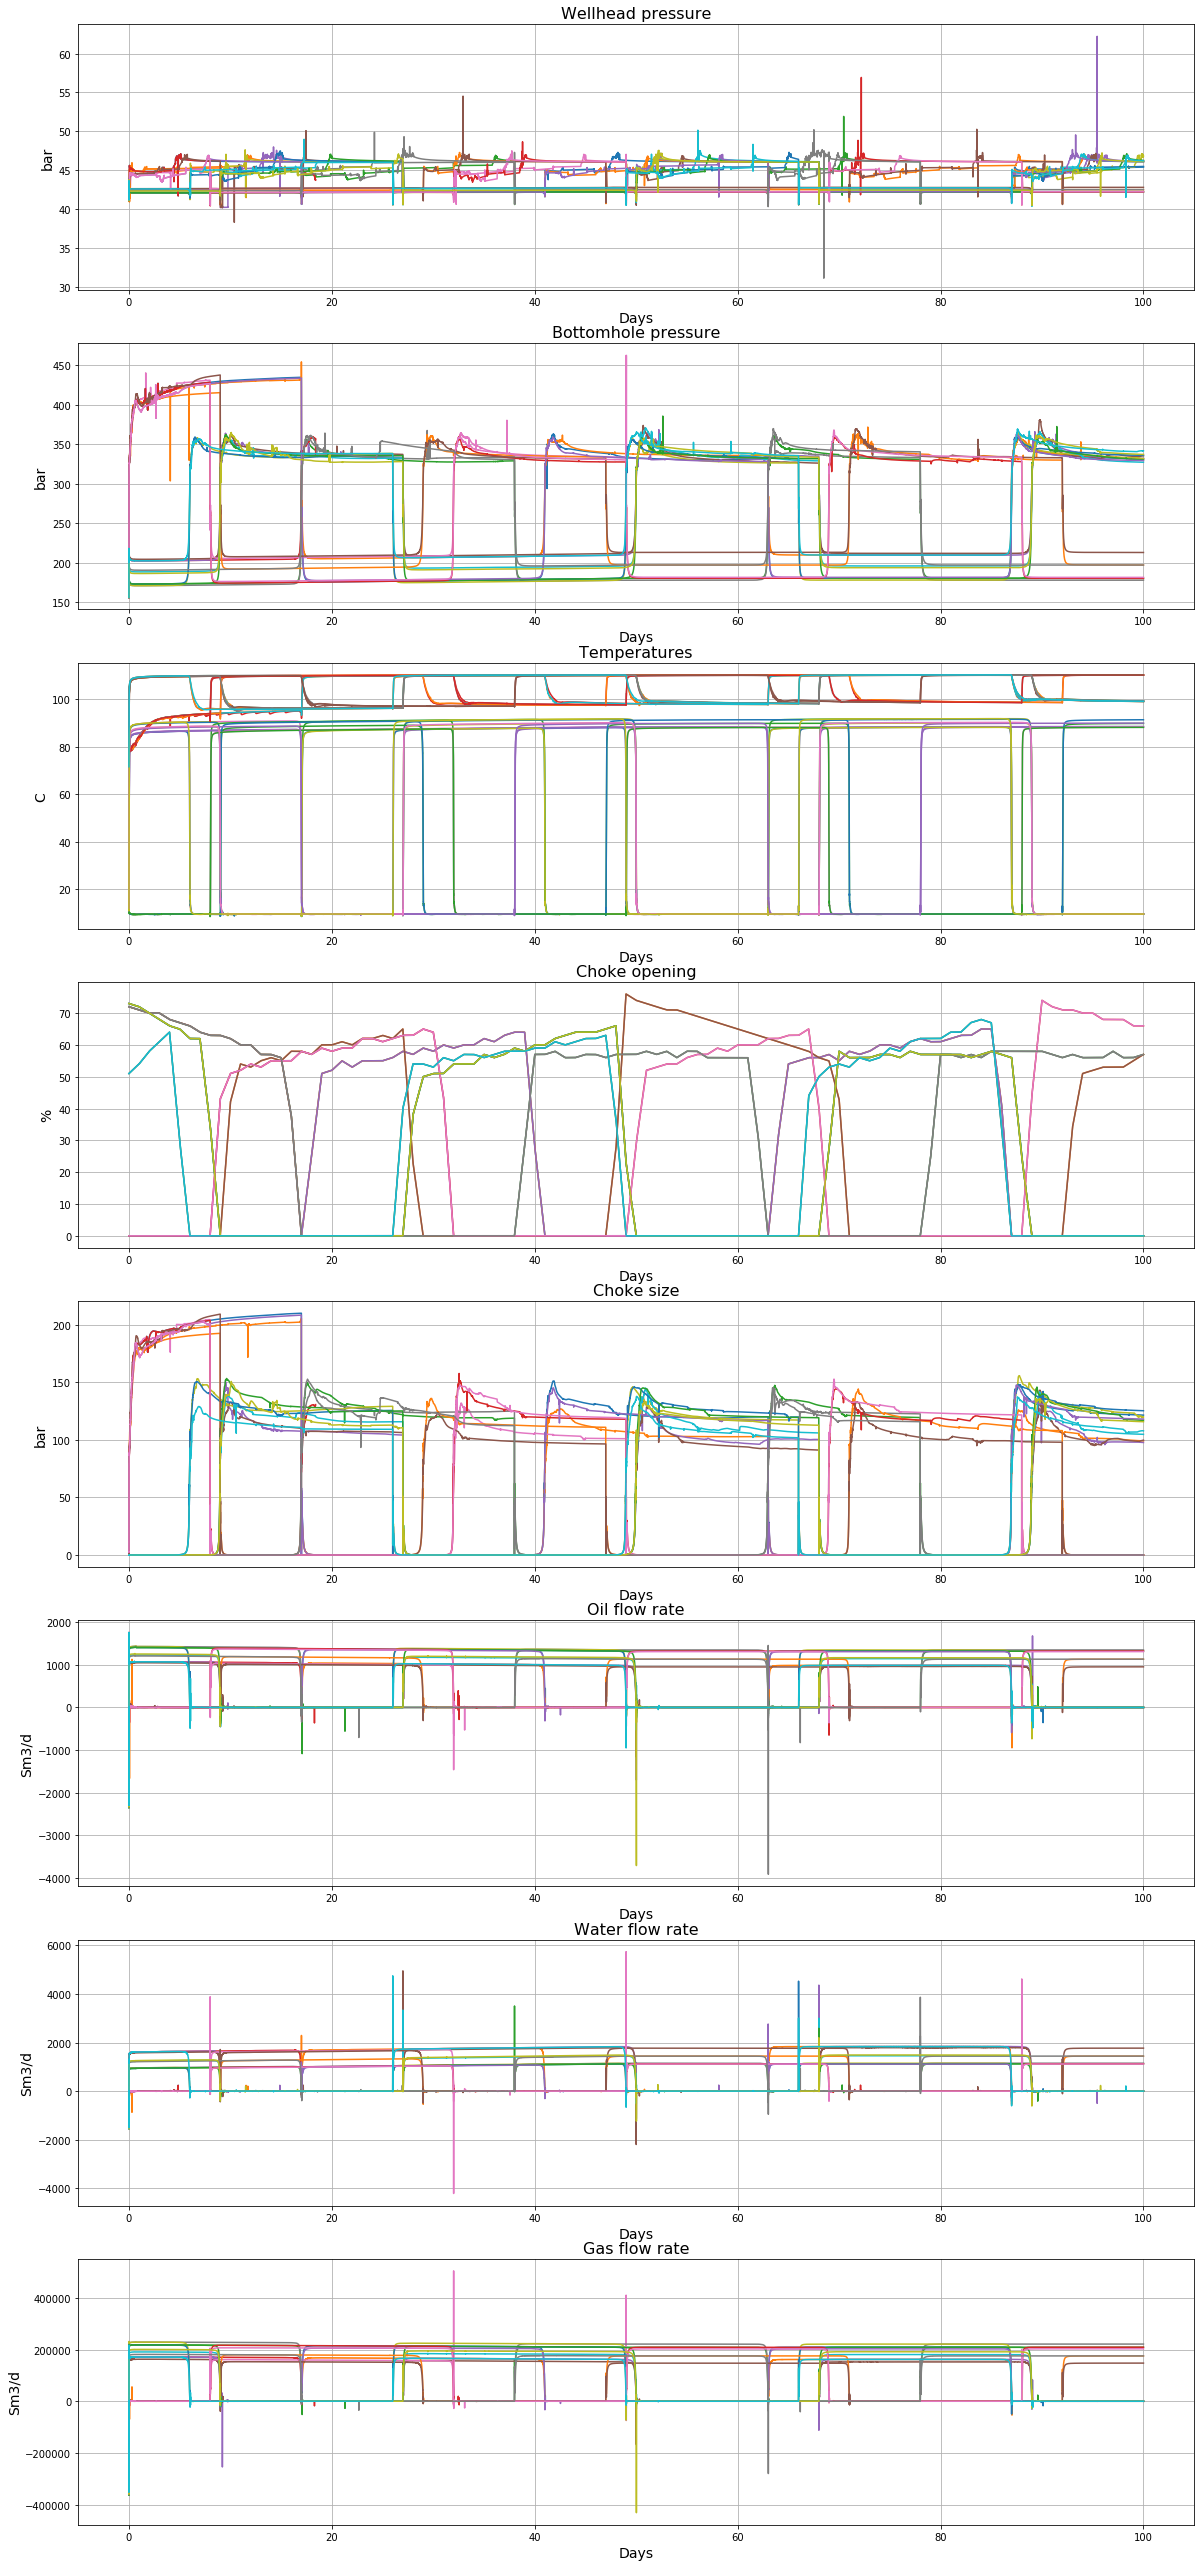

In [35]:
plot_cases(gens, csv_files)

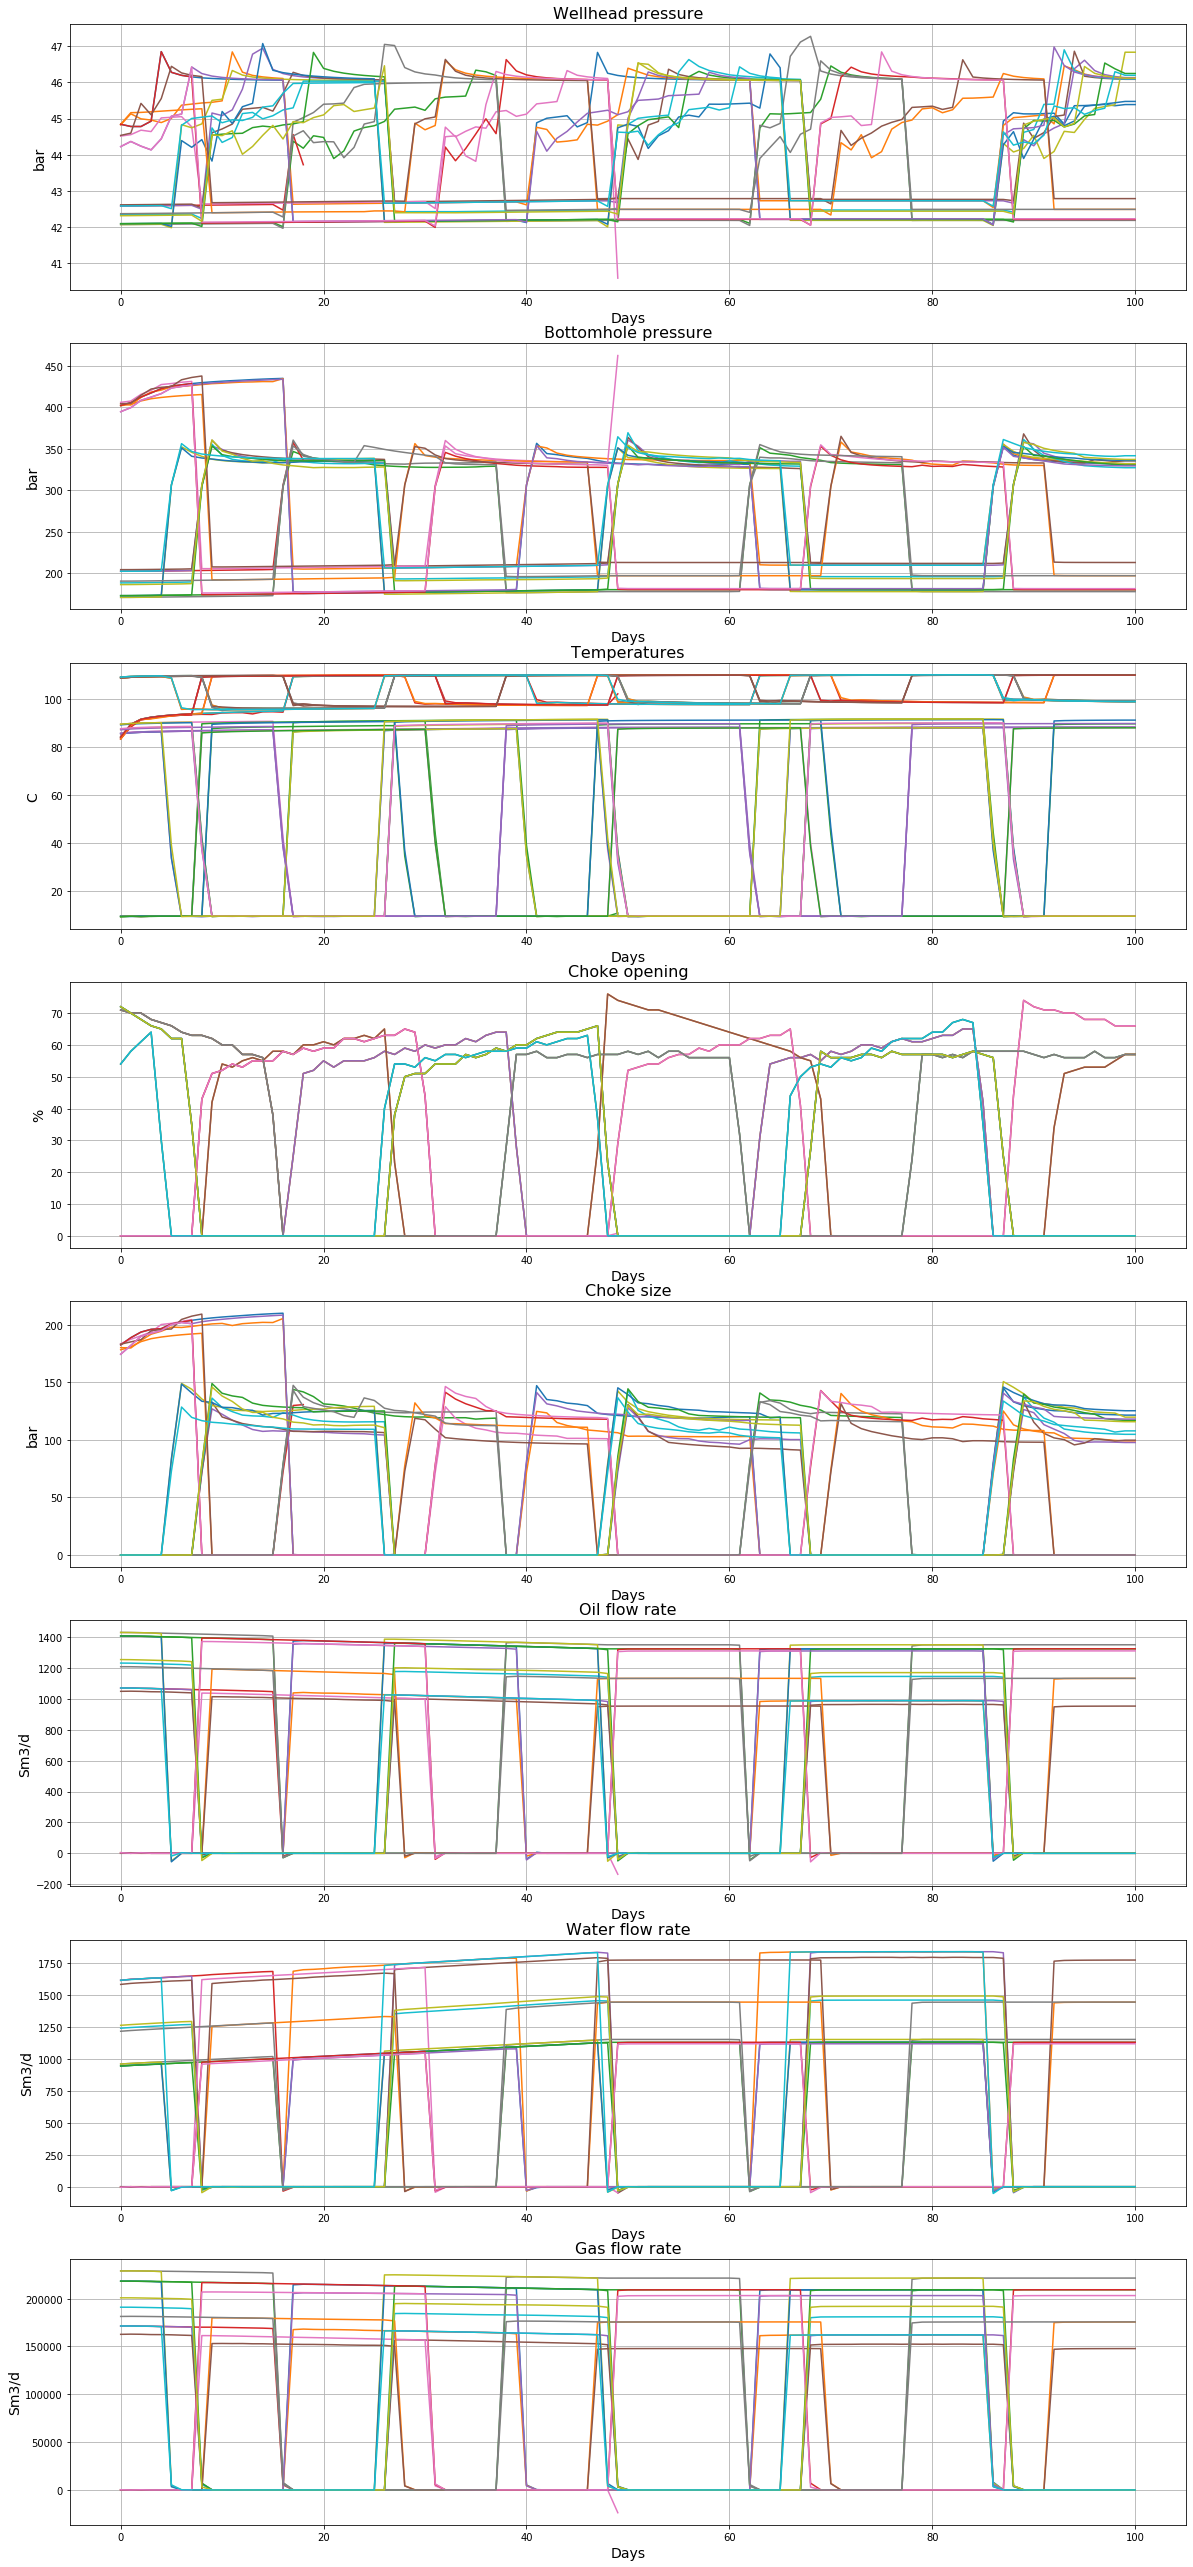

In [36]:
plot_cases(lsts, csv_files)

### Save the resulting datasets

In [37]:
if os.path.exists(GEN_DFS_PATH):
    # remove old files, if they exist
    for file in os.listdir(GEN_DFS_PATH):
        os.remove(f'{GEN_DFS_PATH}/{file}')
else:
    os.makedirs(GEN_DFS_PATH)

for i, fname in enumerate(tqdm(csv_files_ordered)):
    gen = pd.read_csv(f"{path_norm}/{fname}.csv", sep=',')
        
    gen = gen.drop(columns=to_drop)
    gen = gen.rename(columns=cols)

    gen.DATEPRD /= 86400         # sec do day
    gen.AVG_CHOKE_SIZE_P *= 1e2  # shares to %
    gen[pressures] /= 1e5        # Pa to bar
    gen[rates] *= 86400          # Sm3/S to Sm3/d
    
    gen['Day'] = np.trunc(gen.DATEPRD).astype(int)
    lst = gen.groupby('Day').tail(1).reset_index(drop=True).set_index('Day')
    lst[lst < 0] = 0
    lst = lst.drop(columns='DATEPRD')
    lst.to_csv(f'{GEN_DFS_PATH}/gen_{i}.csv')